In [2]:
# University of St Thomas 
# SEIS 764 AI Fall 2022, Prof. Chih Lai
#
# TEAM PROJECT
#
# Jamie Boehme
# Jonathan Ditlevson
# Satya Dampanaboyina
# Swetha Doddi
# Stan Kegel
#
# INITIAL STRAWMAN VERSION - 06-NOV-2022 - stan_20221106v1.ipynb
#
# WORK IN PROGRESS COMMENTARY...
#
# PROBLEMS / MYSTERIES
# 1) Why does accuracy obtained with predict method on validation/test data not 
#    agree with validation accuracy reported during fit epoch?? (This problem has
#    been seen both with and without checkpointing the model.)
#
# HOPEFUL IMPROVEMENT IDEAS [To Try Next]:
# 1)  Use improved image set, with fewer discarded images from baseline set.  (Jon has been working on that.)
#     A few more imagees might make a big difference.
# 2)  Look at any ideas found / researched by other team members since kick-off meeting
# 3)  Use better pre-trained CNN srchitecture, tuned to handle images with multiple granularities of interest 
#     (It looks like Inception-Network may fit the )
#     -- Ref. https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202
#     NOTE: Don't forget to change preprocessing function when changing pre-learned model!  (SEE IMPORT STATEMENT 
#     FOR "preporcess_input" NEAR TOP OF NOTEBOOK.)
# 4)  Look at adding Regularization -- add regularizer to dense layers, add drop out regularization layers
#     -- Ref. https://jinwen17.medium.com/tricks-to-prevent-overfitting-in-cnn-model-trained-on-a-small-dataset-b84f05eb4eb7
#   
# SUBSEQUENT LIKELY IMPROVEMENTS [Later / After we hopefully get accuracy in the 90s]:
# 1)  Fine Tuning (Unfreezing a few layers of pre-trained CNN) 
#     - Ref: https://keras.io/guides/transfer_learning/
#     - Ref. https://www.tensorflow.org/guide/keras/transfer_learning
# 2)  Consider adding "Early Stopping"
#
# OTHER POSSIBLE IMPROVEMENT IDEAS:
# 1)  Experiment with optimizer functions, learning rate, momentum (shouldn't it be called inertia?), 
#     learning rate decay, and batch size.  (already tried this to some extent)
#     -- Ref. https://keras.io/api/optimizers/
# 2)  Look into image/pixel normalization
#     -- Ref. https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
#     -- Ref. https://theailearner.com/2019/07/06/keras-imagedatagenerator-normalization-at-validation-and-test-time/#
# 3)  Experiment with augmentation options (already tried this to some extent)
#
# SPECULATIVE/DESPERATE [Probably less fruitful] IMPROVEMENT IDEAS:
# 1)  Try a custom CNN with larger image area ingestion (and simpler design) 
# 2)  Try multiple models / ensemble voting (oof-da)
#

from datetime import datetime
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.resnet import preprocess_input
from PIL import Image
from torchvision import transforms

# parameters for image data 

from google.colab import drive
drive.mount('/content/drive')
dir_path = "/content/drive/My Drive/Crops"


img_class_mode_ = 'categorical'
rotation_range_ = 15       # 15 degrees rotation range for image augmentation
width_shift_range_ = 0.15  # 15% horizontal shift range for image augmentation
height_shift_range_ = 0.15 # 15% pixels veritcal shift range for image augmentation
zoom_range_ = 0.3          # zoom range 0.7 - 1.3 for image augmentation
brightness_range_ = (0.3, 0.8)   # brightness range 50% to 100% for image augmentation
horizontal_flip_ = True    # horizontal flip on for image augmentation
interpolation_mode_ = "lanczos"  # higher quality interpolation for re-scaling (when applicable)
fill_mode_ = "reflect"  # reflect margin for shifted regions for image augmentation
keep_aspect_ratio_ = True

# parameters for learning
img_batch_size_ = 10 
checkpoint_path = "model_checkpoint_" + datetime.now().strftime('%Y%m%d-%H%M%S') + ".h5"

# fix model.py: Line #170 in_channels = inputs.shape[-1]
!git clone https://github.com/rkuo2000/keras-deeplab-v3-plus 
%cd keras-deeplab-v3-plus


# load data and split into training and test/validation data sets
images_data = ImageDataGenerator(
    rescale=1. / 255, 
    preprocessing_function = preprocess_input,  # Ref. https://keras.io/api/applications/vgg/#vgg19-function
    validation_split = 0.25,
    rotation_range = rotation_range_, width_shift_range = width_shift_range_,
    height_shift_range = height_shift_range_, zoom_range = zoom_range_,
    horizontal_flip = horizontal_flip_, fill_mode = fill_mode_, 
    brightness_range = brightness_range_)
trainD_shuffle = images_data.flow_from_directory(
    dir_path, shuffle = True, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
trainD_mask = images_data.flow_from_directory(
    dir_path, shuffle = True, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
trainD_noshuffle = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,    
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
testD_noshuffle = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'validation')
testD_mask = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'validation')


Mounted at /content/drive
Cloning into 'keras-deeplab-v3-plus'...
remote: Enumerating objects: 375, done.
remote: Total 375 (delta 0), reused 0 (delta 0), pack-reused 375
Receiving objects: 100% (375/375), 5.12 MiB | 42.61 MiB/s, done.
Resolving deltas: 100% (202/202), done.
/content/keras-deeplab-v3-plus
Found 607 images belonging to 30 classes.
Found 607 images belonging to 30 classes.
Found 607 images belonging to 30 classes.
Found 187 images belonging to 30 classes.
Found 187 images belonging to 30 classes.


In [3]:
train_img_class_count = len(trainD_noshuffle.class_indices)
test_img_class_count = len(testD_noshuffle.class_indices)
if (train_img_class_count != test_img_class_count):
    raise Exception("Training and Testing Data Sets Not Aligned.")
img_class_count = test_img_class_count
print("image class count", img_class_count)

image class count 30


In [5]:
# get pre-trained CNN
#from keras.applications import InceptionResNetV2
#from keras.applications import InceptionV3
from keras.applications import ResNet50V2
cnn = ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
cnn.trainable = False

94668760/94668760 [==============================] - 0s 0us/step


In [6]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
epochs_ = 150

model = Sequential([
    cnn,
    Flatten(),
    Dense(500, activation = 'relu'),
    Dense(250, activation = 'relu'),
    Dense(img_class_count, activation = 'softmax')
])

model.compile(loss = CategoricalCrossentropy(), 
    optimizer=opt, 
     metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 500)               50176500  
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 30)                7530      
                                                                 
Total params: 73,874,080
Trainable params: 50,309,280
Non-trainable params: 23,564,800
_________________________________________________________________


In [8]:
# set up logging 
# and train nerual net

%load_ext tensorboard

log_dir = 'logs/batch/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/train'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, monitor="val_accuracy", batch_size = img_batch_size_,
    verbose=1, mode="max", save_weights_only=True, save_best_only=True)
history = model.fit(trainD_shuffle, epochs = epochs_, validation_data = testD_noshuffle, 
    callbacks=[tensorboard_callback, checkpoint_callback])


Epoch 1/150
50/61 [=======================>......] - ETA: 23s - loss: 3.0444 - accuracy: 0.2515

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


61/61 [==============================] - ETA: 0s - loss: 2.9286 - accuracy: 0.2883
Epoch 1: val_accuracy improved from -inf to 0.48128, saving model to model_checkpoint_20221123-013454.h5
61/61 [==============================] - 188s 3s/step - loss: 2.9286 - accuracy: 0.2883 - val_loss: 2.0598 - val_accuracy: 0.4813
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.6606
Epoch 2: val_accuracy improved from 0.48128 to 0.52406, saving model to model_checkpoint_20221123-013454.h5
61/61 [==============================] - 23s 382ms/step - loss: 1.2336 - accuracy: 0.6606 - val_loss: 1.6916 - val_accuracy: 0.5241
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.7759
Epoch 3: val_accuracy did not improve from 0.52406
61/61 [==============================] - 20s 330ms/step - loss: 0.7816 - accuracy: 0.7759 - val_loss: 1.9684 - val_accuracy: 0.5187
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 

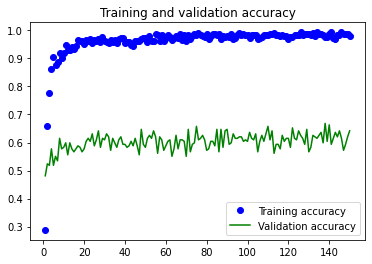

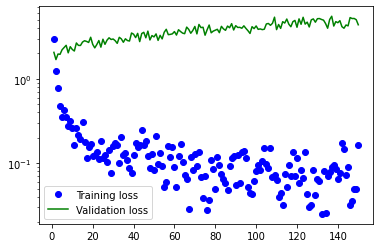

In [9]:
# CHANGE:  Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "g", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "g", label = "Validation loss")
plt.yscale("log")
plt.legend()
plt.show()

In [11]:
# restore checkpoint model
#model = keras.models.load_model(checkpoint_path)
model.load_weights(checkpoint_path)


In [13]:
# run prediction based on training data
train_scores = model.predict(trainD_noshuffle)
train_pred_labels = train_scores.argmax(axis = 1)


 5/61 [=>............................] - ETA: 10s

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


61/61 [==============================] - 16s 250ms/step


In [14]:
# evaluate trained network
print('')
print('')
print('Model Evaluation Using Training Data:')

print("Accuracy Score")
print(accuracy_score(trainD_noshuffle.labels, train_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(trainD_noshuffle.labels, train_pred_labels))




Model Evaluation Using Training Data:
Accuracy Score
0.9835255354200988
Confusion Matrix
[[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0  0  0 19  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  

In [16]:
# run prediction based on test data
test_scores = model.predict(testD_noshuffle)
test_pred_labels = test_scores.argmax(axis = 1)


19/19 [==============================] - 6s 291ms/step


In [17]:
# print confusion matrix 
print('')
print('')
print('Model Evaluation Using Test Data:')


print("Accuracy Score")
print(accuracy_score(testD_noshuffle.labels, test_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(testD_noshuffle.labels, test_pred_labels))




Model Evaluation Using Test Data:
Accuracy Score
0.6417112299465241
Confusion Matrix
[[3 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 6 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 4 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 4 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 6

In [18]:
# Create lookup to convert class labels (index-numbers) to string labels 
nameToLabelDict = testD_noshuffle.class_indices
labelToNameDict = dict([(value, key) for key, value in nameToLabelDict.items()])

In [19]:
# set up lists of colors and styles for use in plotting
from itertools import cycle
from itertools import product
from sklearn.linear_model import LassoCV
import matplotlib as mpl
color_list = [\
    "b", "r", "g", "c", "m", \
    "skyblue", "pink", "lime", "cyan", "magenta", \
    "navy", "brown", "olive", "orange", "purple"]
    # note "cyan" is brighter than "c", "magenta" is brighter than "m"

# repeat each style times number of colors
base_style_list = ['solid', 'dotted', 'dashed', 'dashdot']
line_style_list = \
    [cartesian[0] for  cartesian in product(base_style_list, color_list)]

# set up plot styling
mpl.style.use('seaborn')

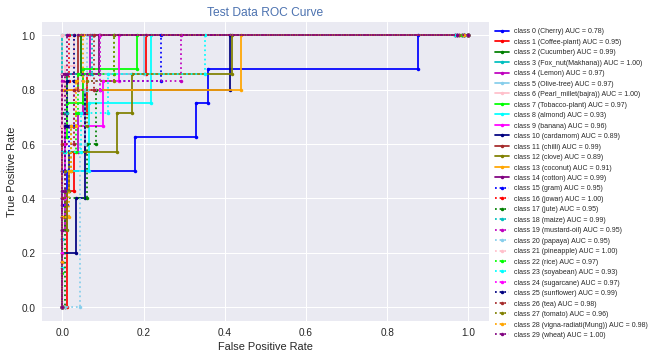

In [20]:
# Plot ROC (Receiver Operating Characteristic) Curve and compute area under curve for each class 
# using test data
import matplotlib as mpl
import seaborn as sms
mpl.style.use('seaborn')
import matplotlib.pyplot as plt
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots()
for i, c, l in zip(range(img_class_count), cycle(color_list), line_style_list):
    fpr_, tpr_, _ = roc_curve(testD_noshuffle.labels, test_scores[:, i], pos_label=i)
    auc_ = auc(fpr_, tpr_)
    label_ = 'class ' + str(i) + " (" + labelToNameDict[i] + ") AUC = %0.2f)" % auc_
    plt.plot(fpr_, tpr_, marker='.', label=label_, color = c, linestyle = l)
plt.title("Test Data ROC Curve", color='C6')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend(bbox_to_anchor = (1.0,1.0), loc = "upper left", fontsize = "x-small")
#plt.legend()
plt.show()

In [21]:
# Print precision, recall, F-score for each class 
# using test data
from sklearn.metrics import classification_report
scores = classification_report(testD_noshuffle.labels, test_pred_labels)
print(scores)

              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.44      0.57      0.50         7
           2       0.75      0.86      0.80         7
           3       1.00      0.80      0.89         5
           4       0.50      0.57      0.53         7
           5       1.00      0.86      0.92         7
           6       0.80      0.89      0.84         9
           7       0.67      0.75      0.71         8
           8       1.00      0.50      0.67         4
           9       0.80      0.67      0.73         6
          10       0.22      0.40      0.29         5
          11       1.00      0.80      0.89         5
          12       0.50      0.29      0.36         7
          13       0.50      0.80      0.62         5
          14       0.60      0.86      0.71         7
          15       1.00      0.50      0.67         6
          16       1.00      0.67      0.80         6
          17       0.33    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
